In [1]:
## Imports
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
## Pay-to-exit research questions
## RQ1 For an adversary with \alpha stake, how much does it need to pay to
## exiting validators to achieve \alpha'\leq0.33 stake in the system? In this scenario the adversary would 
## reimburse all expected rewards to the validator for the next 1-2-3 (TBD) years (discounted at present value).
## RQ2 The same as in RQ1 but the adversary only reimburses the opportunity cost, i.e.,
## say the difference between validator rewards - Uniswap LP rewards (assuming Uniswap LP is the 2nd best option for validators).

In [3]:
## Best resource on the protocol: https://eth2book.info/latest/book.pdf

In [4]:
## Pay-to-fork research questions
## RQ1 how much the adversary needs to pay for buying X attestations?
## RQ2 Same as RQ1 but the adversary also needs to cover attestation equivocation penalties for these X bought attestations.

In [5]:
## Some constants that we deem given (maybe periodically update)
stakedETHamount = 34385053 ## (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking 
noOfValidators = 1074533 ## (2025.04.01) taken from here https://dune.com/hildobby/eth2-staking
noEpochsPerYear = 82181.25
maxIssuancePerYear = 940.8659*math.sqrt(noOfValidators) ## the constant is coming from epochs per year (roughly)
APR = 2940.21/math.sqrt(noOfValidators)
proposerReward = 0
attestationReward = 0
W_s = 14 # weights page 100
W_t = 26
W_h = 14
W_y = 3 ## sync reward weight
W_p = 12.5 ## proposer weight
W_Sigma = 64 ## defined at page 109
T = stakedETHamount ## defined at page 102
n = 32 ## number of increments (the validator's balance is assumed to be 32 ETH uniformly (for the sake of simplicity))
base_reward_factor = 64 ## https://ethereum.stackexchange.com/questions/153722/base-reward-formula-enquiry
b = (1000000000*base_reward_factor)/math.sqrt(32000000000*noOfValidators) ## base reward per increment
## Attestation penalties page 109 in eth2book
attestation_missing_penalty = 0.625*T*b ## page 107
wrong_source_attestation = (-W_s-W_t)/W_Sigma
MIN_SLASHING_PENALTY_QUOTIENT_BELLATRIX = 1/32 ##defined at page 116
## correlation penalty page 117
## other penalties

attestation_reward_per_validator = (b / 64) * 57 / 1e9  # ETH

In [6]:
## Relevant Pectra-EIPs for this work
## EIP-7002
## EIP-7549 Move the committee index out of the signature: more efficient attestation/signature aggregation 

In [7]:
print(maxIssuancePerYear,"ETH issued per year")
print(APR,"% APR")

975298.6148563978 ETH issued per year
2.8364064971488903 % APR


In [8]:
def getMaxIssuancePerYear(noOfValidators):
    return 940.8659*math.sqrt(noOfValidators)

In [9]:
def getAPR(noOfValidators):
    return 2940.21/math.sqrt(noOfValidators)

In [11]:
nowValidators = 1074533
noOfBribedValidators = 300000
oneYearRewards = [32*getAPR(i)/100 for i in range(nowValidators,nowValidators-noOfBribedValidators,-1)]
bribeAmounts = [sum(oneYearRewards[:i]) for i in range(len(oneYearRewards))]

KeyboardInterrupt: 

In [12]:
plt.plot(bribeAmounts)
plt.xlabel("$\#$Bribed Validators")
plt.ylabel("Bribe Amount (ETH)")
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\#'
<>:2: SyntaxWarning: invalid escape sequence '\#'
/var/folders/wy/6ckq2ykx4w7_xd9ml5_tzm_m0000gn/T/ipykernel_13522/2351514803.py:2: SyntaxWarning: invalid escape sequence '\#'
  plt.xlabel("$\#$Bribed Validators")
/var/folders/wy/6ckq2ykx4w7_xd9ml5_tzm_m0000gn/T/ipykernel_13522/2351514803.py:2: SyntaxWarning: invalid escape sequence '\#'
  plt.xlabel("$\#$Bribed Validators")


NameError: name 'bribeAmounts' is not defined

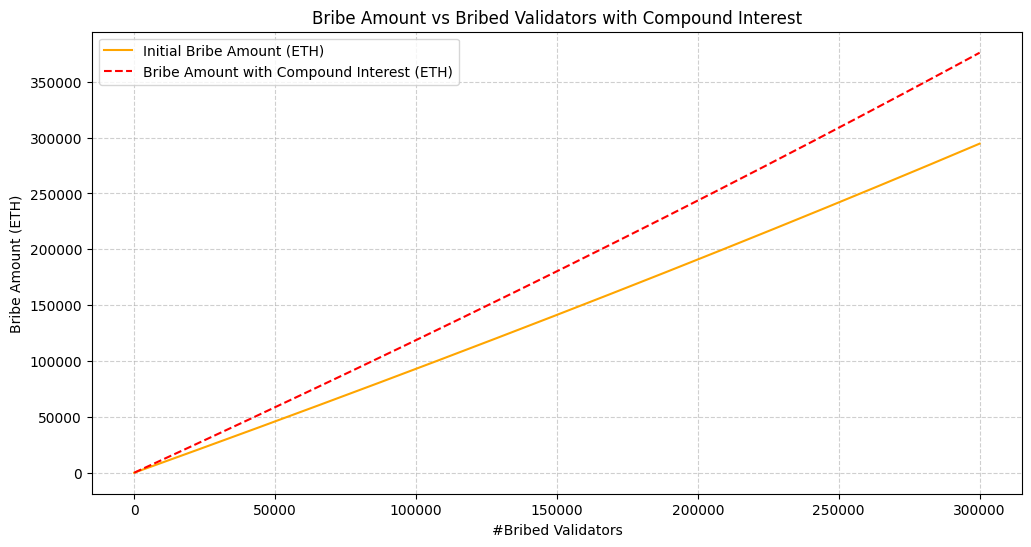

In [13]:
stakedETHAmount = 34385053             # Total staked ETH (2025.04.01)
noOfValidators = 1074533               # Number of validators (2025.04.01)
noOfBribedValidators = 300000          # Number of bribed validators

def getAPR(noOfValidators):
    return 2940.21 / np.sqrt(noOfValidators)

oneYearRewards = [32 * getAPR(i) / 100 for i in range(noOfValidators, noOfValidators - noOfBribedValidators, -1)]
bribeAmounts = np.cumsum(oneYearRewards)  

interest_rate = 0.05  # 5% annual interest rate
years = 5 

bribeWithInterest = bribeAmounts * (1 + interest_rate) ** years

plt.figure(figsize=(12, 6))
plt.plot(bribeAmounts, label="Initial Bribe Amount (ETH)", color='orange')
plt.plot(bribeWithInterest, label="Bribe Amount with Compound Interest (ETH)", linestyle="--", color='red')
plt.xlabel("#Bribed Validators")
plt.ylabel("Bribe Amount (ETH)")
plt.title("Bribe Amount vs Bribed Validators with Compound Interest")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


# Fontos

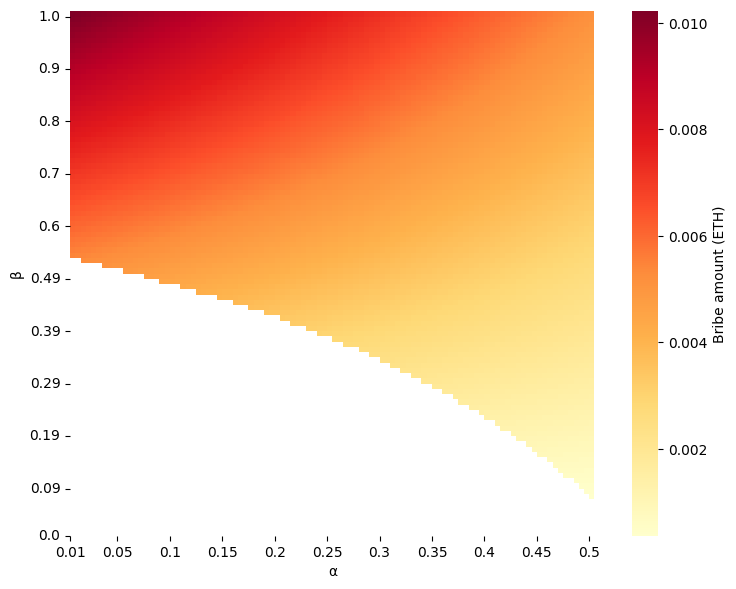

In [14]:
alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals = np.linspace(0, 1, 100)

# L = 2 # fork_lengths
# F0 = 2
# k = 0.1
# canonical_length = 2
# F = F0 * np.exp(-k * L)

bribe = np.full((len(beta_vals), len(alpha_vals)), np.nan)

for i, beta in enumerate(beta_vals):
    for j, alpha in enumerate(alpha_vals):

        lhs = 2 * (1 - alpha) * (1 - beta)
        #lhs = F * (1 - beta) * (1 - alpha) * L + (1 - alpha) * canonical_length

        rhs = 0.4 + alpha + (1 - alpha) * beta
        #rhs = alpha * canonical_length + F * alpha * L + F * beta * (1 - alpha) * L

        if lhs < rhs:

            bribe[i, j] = beta * (1 - alpha) * noOfValidators * attestation_reward_per_validator / 32
            #bribe[i, j] = L * beta * (1 - alpha) * noOfValidators * attestation_reward_per_validator / 32

        # ábrázolni: (1-\alpha) \cdot \beta


vmin_bribe = np.nanmin(bribe)
vmax_bribe = np.nanmax(bribe)

xticks_idx = np.linspace(0, len(alpha_vals)-1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals)-1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(bribe, cmap = "YlOrRd", mask = np.isnan(bribe), square = True, xticklabels = xticks, yticklabels = yticks[::-1],
                 cbar_kws={'label': 'Bribe amount (ETH)'}, vmin = vmin_bribe, vmax = vmax_bribe)

ax.set_xlabel("α")
ax.set_ylabel("β")
ax.set_xticks(xticks_idx)
ax.set_xticklabels(xticks, rotation=0, ha='center')
ax.set_yticks(yticks_idx)
ax.set_yticklabels(yticks, rotation=0, va='center')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

$$ \text{bribe} = \frac{\beta \cdot (1 - \alpha) \cdot noOfValidators \cdot attestation\_reward\_per\_validator}{32} $$

$$ \text{rhs} = 0.4 + \alpha + (1 - \alpha) \cdot \beta $$

$$ \text{lhs} = 2 \cdot (1 - \alpha) \cdot (1 - \beta) $$

# Nem fontos

### Színskálák értelmezése
* kék színskála: adott alpha (a bribelt validátor részesedése) és beta (a bribelt stake aránya) értékeknél mekkora az attack success, vagyis mennyivel több jutalmat kapna a validátor, ha elfogadná a megvesztegetést, mint ha a honest blokkot támogatná
* piros színskála: a támadónak szükséges megvesztegetési költséget mutatja

### Második verzio:
* allithato canonical_length
* honest validator jutalma nem csak az azonnali blokk jutalombol all, hanem a kanonikus lancon elert tovabbi jutalmakbol
lhs = F * (1 - beta) * (1 - alpha) * L + D * (1 - alpha) * canonical_length
* nagyobbak az ertekekek mert nott a jutalom is, igy tobb jutalmat kell kinalnia a tamadonak (noveli az rhs-lhs kulonbseget es csak nagyobb beta es kisebb alpha tartomanyban eri csak meg a tamadas)
* Csokken a tamadas nyeresege, ahogy no a fork hossza (exponencialisan) F = F0 * np.exp(-k * L)

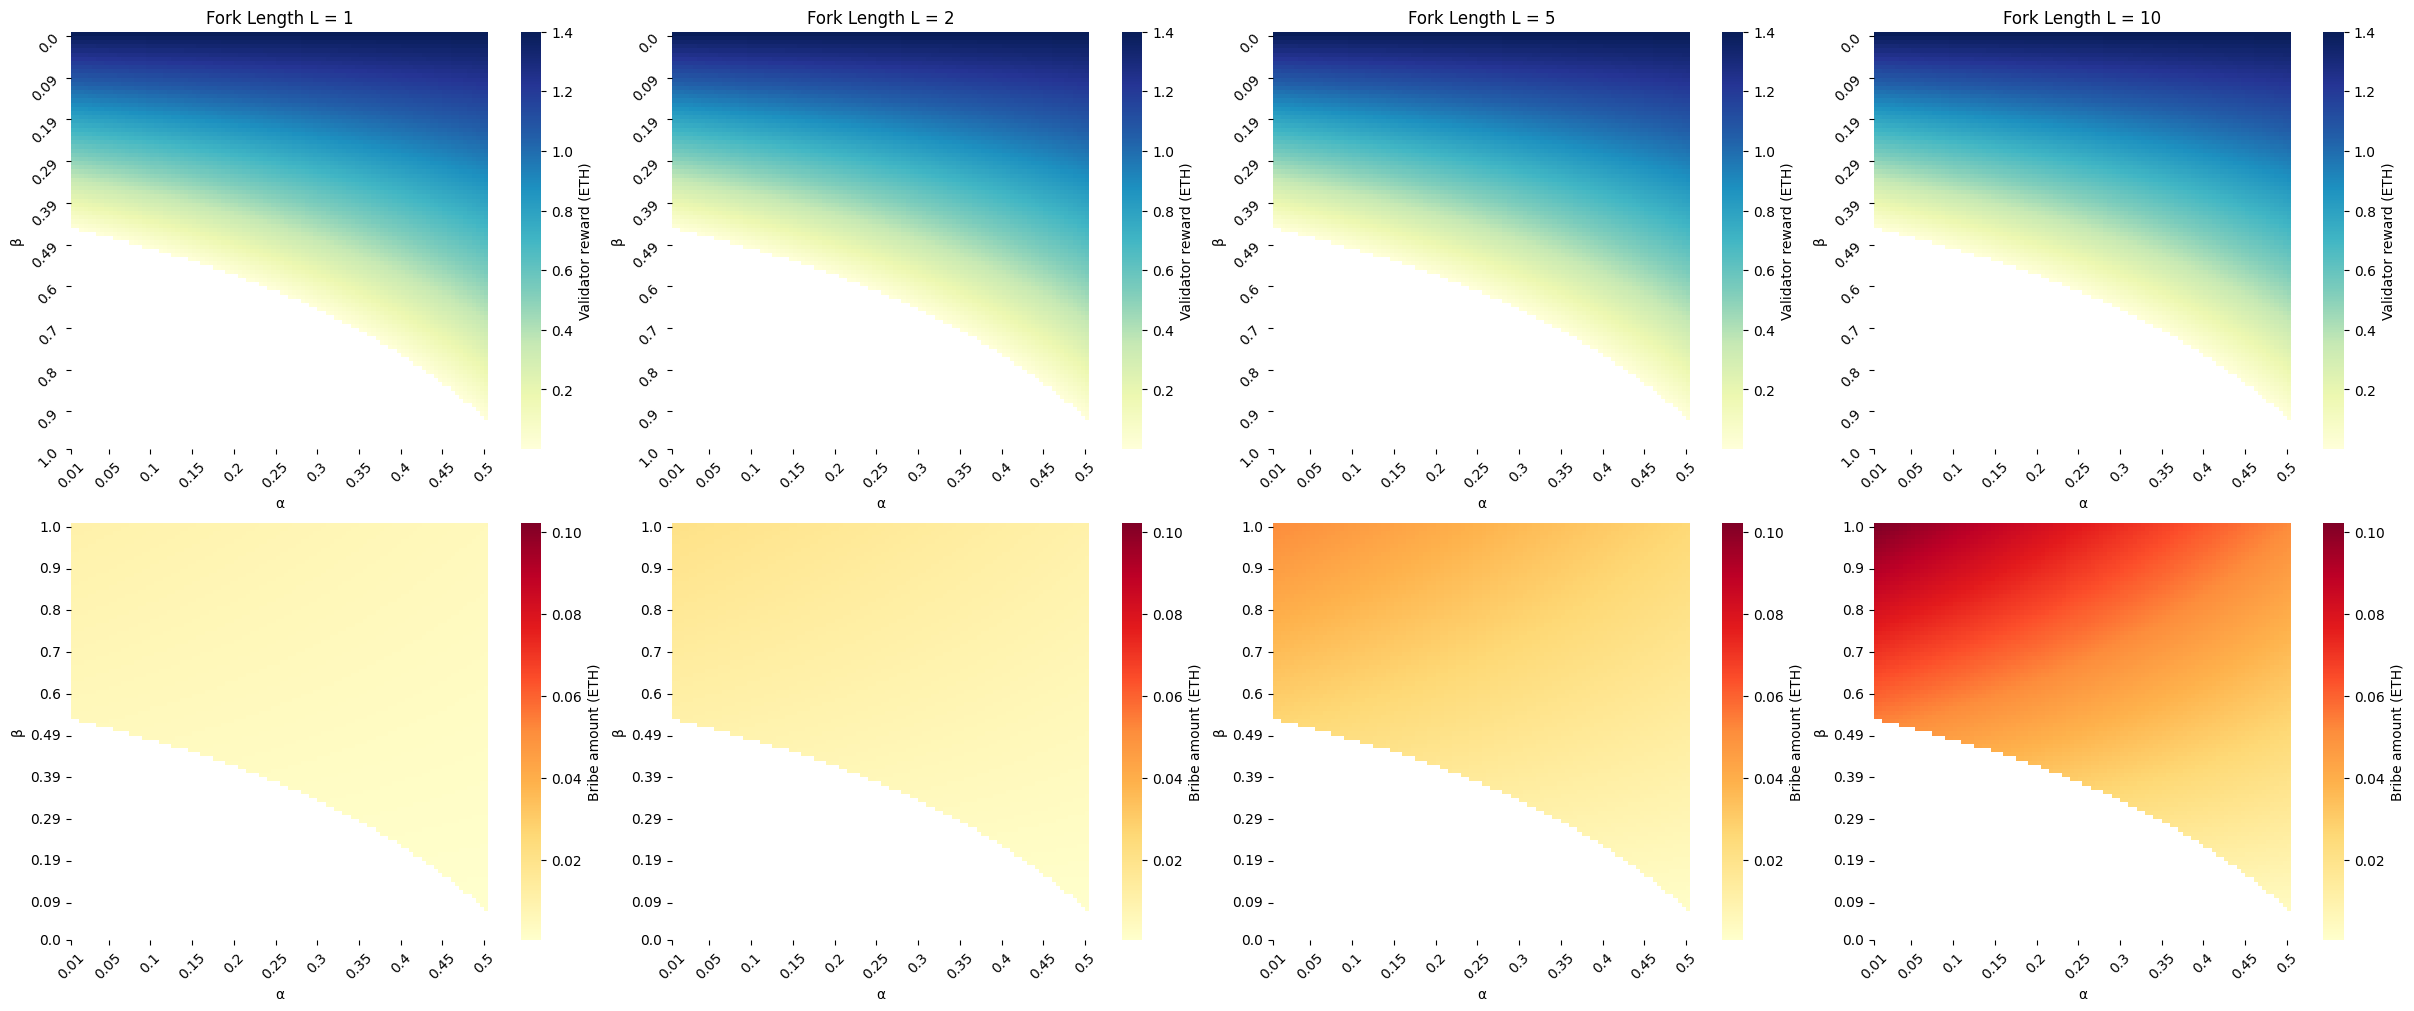

In [15]:
alpha_vals = np.linspace(0.01, 0.5, 100)
beta_vals = np.linspace(0, 1, 100)
fork_lengths = [1, 2, 5, 10]

F0 = 2
k = 0.1

canonical_length = 2

heatmaps_success = []
heatmaps_bribe = []

for L in fork_lengths:
    F = F0 * np.exp(-k * L)
    success = np.full((len(beta_vals), len(alpha_vals)), np.nan)
    bribe = np.full((len(beta_vals), len(alpha_vals)), np.nan)

    for i, beta in enumerate(beta_vals):
        for j, alpha in enumerate(alpha_vals):
            lhs = 2 * (1 - alpha) * (1 - beta)
            #lhs = F * (1 - beta) * (1 - alpha) * L + (1 - alpha) * canonical_length
            rhs = 0.4 + alpha + (1 - alpha) * beta
            #rhs = alpha * canonical_length + F * alpha * L + F * beta * (1 - alpha) * L

            if lhs < rhs:
                success[i, j] = rhs - lhs
                bribe[i, j] = L * beta * (1 - alpha) * noOfValidators * attestation_reward_per_validator / 32

                # ábrázolni: (1-\alpha) \cdot \beta
    heatmaps_success.append(success)
    heatmaps_bribe.append(bribe)


vmin_success = np.nanmin(heatmaps_success)
vmax_success = np.nanmax(heatmaps_success)

vmin_bribe = np.nanmin(heatmaps_bribe)
vmax_bribe = np.nanmax(heatmaps_bribe)

fig, axs = plt.subplots(2, len(fork_lengths), figsize=(24, 10), constrained_layout=True)

xticks_idx = np.linspace(0, len(alpha_vals)-1, 11, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals)-1, 11, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

for idx in range(len(fork_lengths)):
    sns.heatmap(heatmaps_success[idx], cmap = "YlGnBu", mask = np.isnan(heatmaps_success[idx]), xticklabels = False, yticklabels = False, square = True, ax = axs[0, idx],
        linewidths = 0, linecolor = 'none', cbar_kws = {'label': 'Validator reward (ETH)'}, vmin = vmin_success, vmax = vmax_success)
    
    axs[0, idx].set_title(f"Fork Length L = {fork_lengths[idx]}")
    axs[0, idx].set_xlabel("α")
    axs[0, idx].set_ylabel("β")
    axs[0, idx].set_xticks(xticks_idx)
    axs[0, idx].set_xticklabels(xticks, rotation=45)
    axs[0, idx].set_yticks(yticks_idx)
    axs[0, idx].set_yticklabels(yticks[::-1], rotation=45)
    axs[0, idx].invert_yaxis() 

    sns.heatmap(heatmaps_bribe[idx], cmap="YlOrRd", mask=np.isnan(heatmaps_bribe[idx]), xticklabels = False, yticklabels = False, square = True, ax = axs[1, idx],
        linewidths = 0, linecolor = 'none', cbar_kws = {'label': 'Bribe amount (ETH)'}, vmin = vmin_bribe, vmax = vmax_bribe)
    
    axs[1, idx].set_xlabel("α")
    axs[1, idx].set_ylabel("β")
    axs[1, idx].set_xticks(xticks_idx)
    axs[1, idx].set_xticklabels(xticks, rotation=45)
    axs[1, idx].set_yticks(yticks_idx)
    axs[1, idx].set_yticklabels(yticks, rotation=0, va='center')
    axs[1, idx].invert_yaxis()

plt.show()

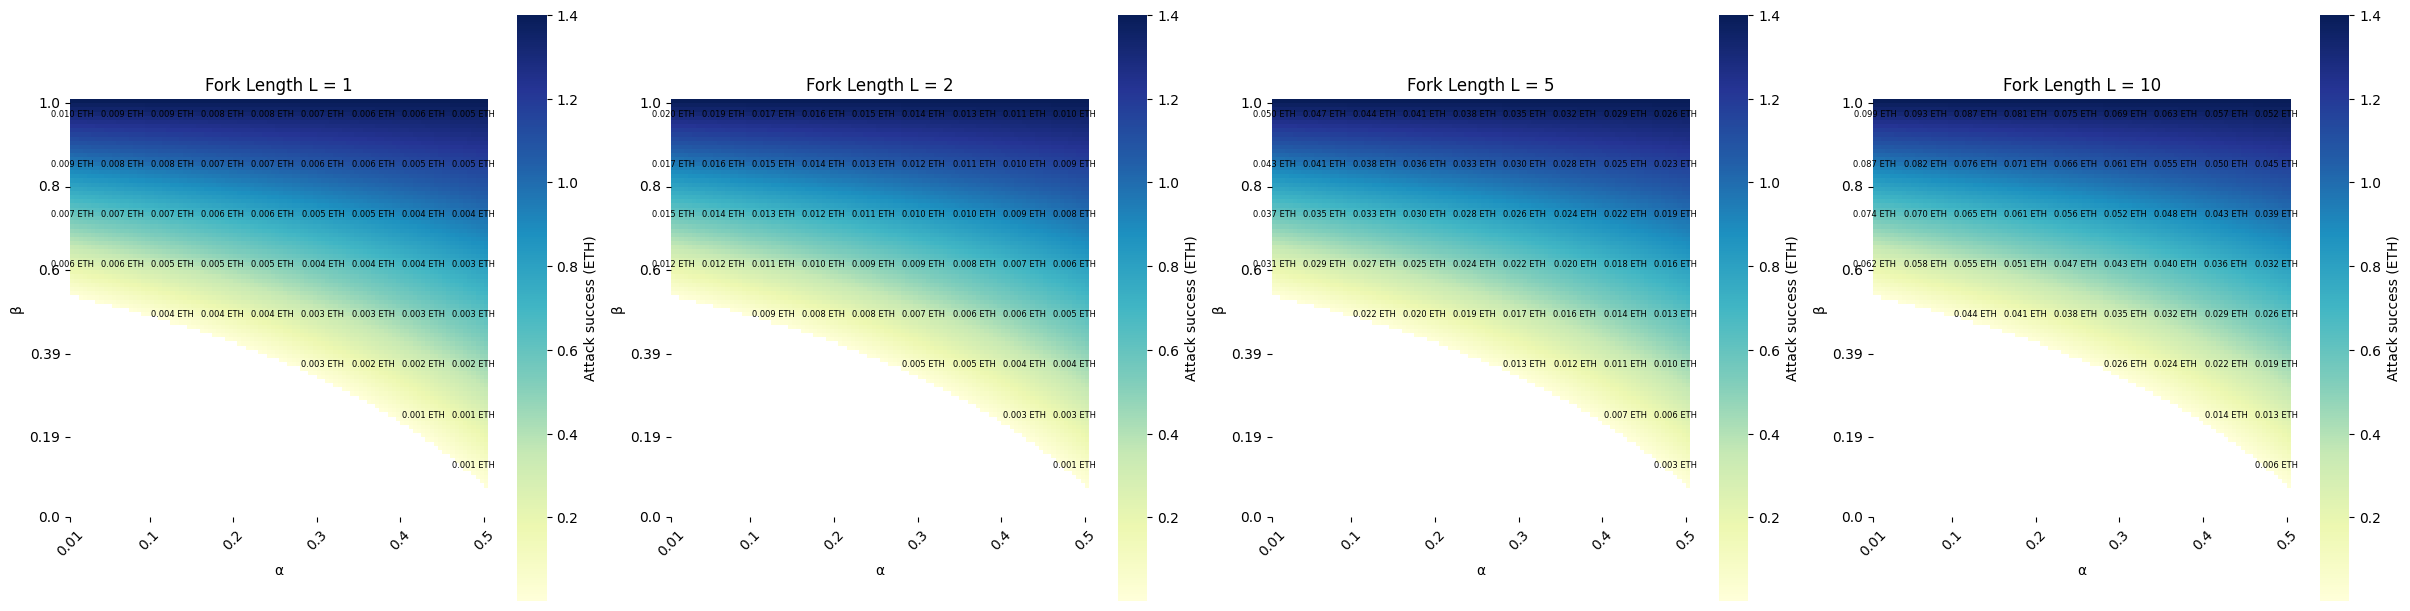

In [16]:
# Egy abran a sikeresseg es a bribe osszege

fig, axs = plt.subplots(1, len(fork_lengths), figsize=(24, 6), constrained_layout=True)

xticks_idx = np.linspace(0, len(alpha_vals)-1, 6, dtype=int)
xticks = np.round(alpha_vals[xticks_idx], 2)

yticks_idx = np.linspace(0, len(beta_vals)-1, 6, dtype=int)
yticks = np.round(beta_vals[yticks_idx], 2)

for idx in range(len(fork_lengths)):
    ax = axs[idx]

    sampled_bribe = heatmaps_bribe[idx].copy()
    for i in range(len(beta_vals)):
        for j in range(len(alpha_vals)):
            if i % 12 != 0 or j % 12 != 0:
                sampled_bribe[i, j] = np.nan

    annotations = np.empty_like(sampled_bribe, dtype=object)
    for i in range(len(beta_vals)):
        for j in range(len(alpha_vals)):
            if not np.isnan(sampled_bribe[i, j]):
                annotations[i, j] = f"{sampled_bribe[i, j]:.3f} ETH"
            else:
                annotations[i, j] = ""


    sns.heatmap(heatmaps_success[idx], cmap = "YlGnBu", mask = np.isnan(heatmaps_success[idx]), square = True, ax = ax, cbar_kws = {'label': 'Attack success (ETH)'},
        annot = annotations, fmt = "", annot_kws = {"size": 6, "color": "black"}, vmin = vmin_success, vmax = vmax_success)

    ax.set_title(f"Fork Length L = {fork_lengths[idx]}")
    ax.set_xlabel("α")
    ax.set_ylabel("β")

    ax.set_xticks(xticks_idx)
    ax.set_xticklabels(xticks, rotation=45)

    ax.set_yticks(yticks_idx)
    ax.set_yticklabels(yticks, rotation=0, va='center')
    ax.invert_yaxis()

plt.show()

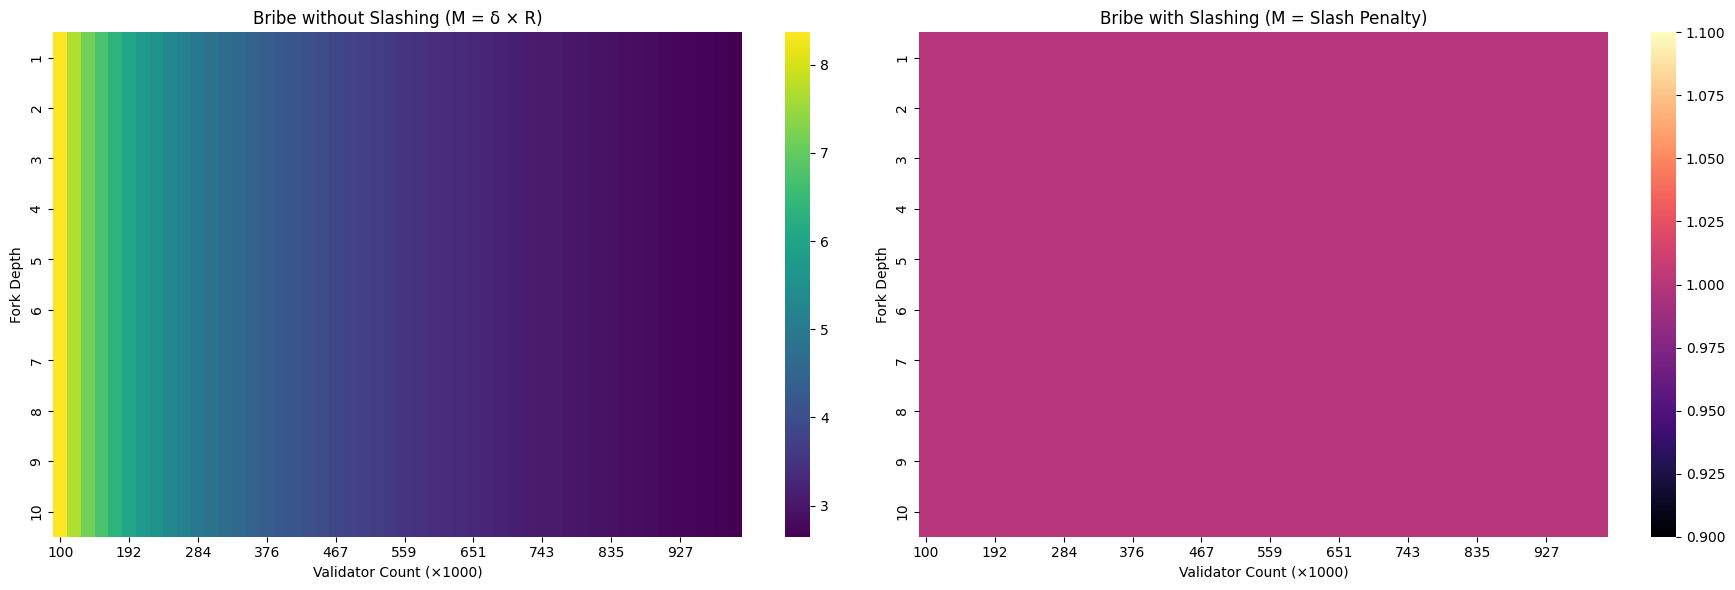

In [17]:
delta = 0.9               # time discount factor
k = 2940.21               # reward constant, approx.
slash_fraction = 1 / 32   # base slashing penalty (simplified)
base_stake = 32           # ETH per validator

def honest_reward(N):
    return k / np.sqrt(N)

def slash_penalty():
    return slash_fraction * base_stake

validator_range = np.linspace(100_000, 1_000_000, 50)
fork_depth_range = np.arange(1, 11)  # from 1 to 10 blocks deep
X, Y = np.meshgrid(validator_range, fork_depth_range)

reward_grid = delta * honest_reward(X)
slashing_grid = slash_penalty() * np.ones_like(X)  # constant

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(reward_grid, ax=axs[0], xticklabels=5, yticklabels=1, cmap='viridis')
axs[0].set_title('Bribe without Slashing (M = δ × R)')
axs[0].set_xlabel('Validator Count (×1000)')
axs[0].set_ylabel('Fork Depth')
axs[0].set_xticklabels(np.round(validator_range[::5] / 1_000).astype(int))
axs[0].set_yticklabels(fork_depth_range)

sns.heatmap(slashing_grid, ax=axs[1], xticklabels=5, yticklabels=1, cmap='magma')
axs[1].set_title('Bribe with Slashing (M = Slash Penalty)')
axs[1].set_xlabel('Validator Count (×1000)')
axs[1].set_ylabel('Fork Depth')
axs[1].set_xticklabels(np.round(validator_range[::5] / 1_000).astype(int))
axs[1].set_yticklabels(fork_depth_range)

plt.tight_layout()
plt.show()

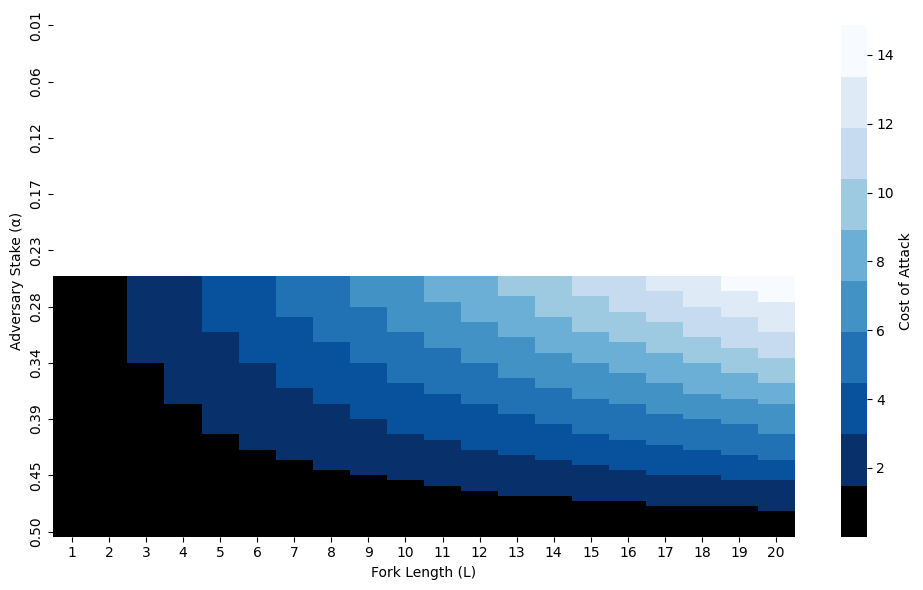

In [18]:
from matplotlib.colors import ListedColormap


fork_lengths = np.arange(1, 21)               # fork hossza
alpha_vals = np.linspace(0.01, 0.5, 100)      # adversary stake

F = 1       # reward on the fork
D = 2       # reward on canonical chain
unit_cost = 1  # cost per unit bribed stake

cost_matrix = np.full((len(alpha_vals), len(fork_lengths)), np.nan)

for i, alpha in enumerate(alpha_vals):
    for j, L in enumerate(fork_lengths):
        betas = np.linspace(0, 1, 1000)
        for beta in betas:
            lhs = F * (1 - beta) * (1 - alpha) * L + D * (1 - alpha) * L
            rhs = D * alpha * L + F * alpha * L + F * beta * (1 - alpha) * L
            if lhs < rhs:
                cost_matrix[i, j] = beta * (1 - alpha) * unit_cost * L
                break

colors = ["black", "#08306b", "#08519c", "#2171b5", "#4292c6",
          "#6baed6", "#9ecae1", "#c6dbef", "#deebf7", "#f7fbff"]
cmap = ListedColormap(colors)



plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    cost_matrix,
    xticklabels=fork_lengths,
    cmap=cmap,
    mask=np.isnan(cost_matrix),
    cbar_kws={'label': 'Cost of Attack'})

ytick_indices = np.linspace(0, len(alpha_vals) - 1, 10, dtype=int)
ytick_labels = [f"{alpha_vals[i]:.2f}" for i in ytick_indices]
ax.set_yticks(ytick_indices)
ax.set_yticklabels(ytick_labels)

plt.xlabel("Fork Length (L)")
plt.ylabel("Adversary Stake (α)")
plt.tight_layout()
plt.show()

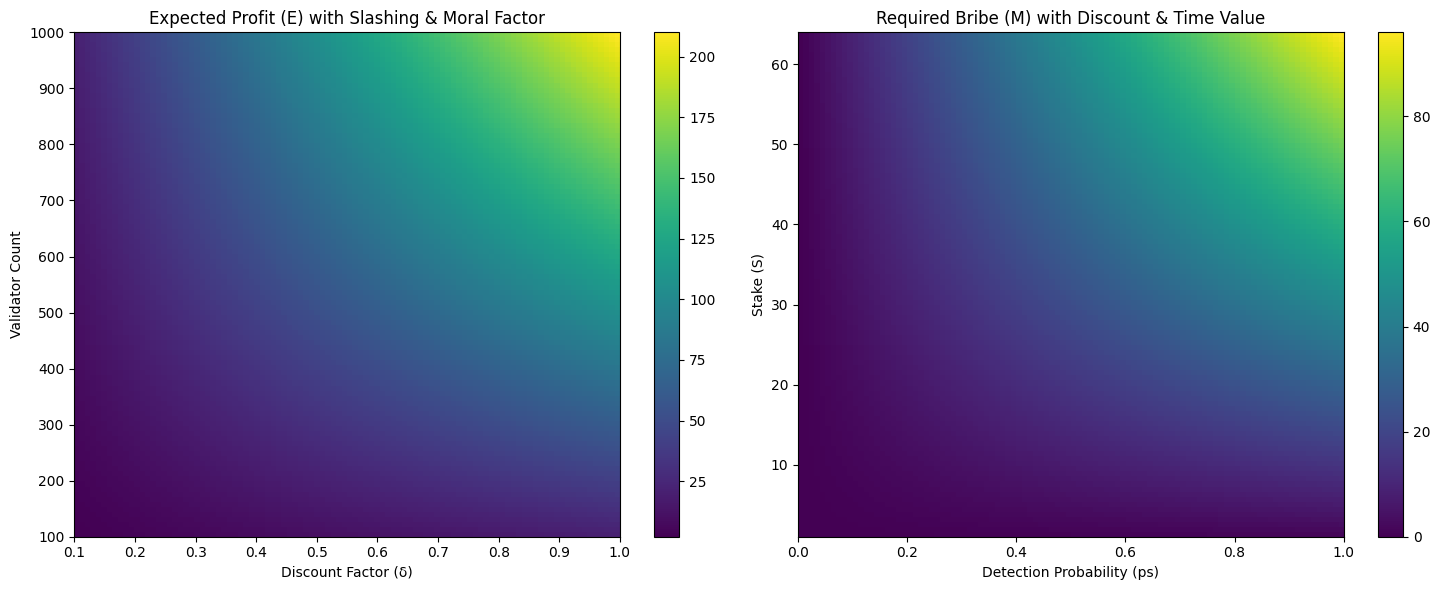

In [19]:
validator_count_range = np.linspace(100, 1000, 100)
delta_range = np.linspace(0.1, 1, 100)
ps_range = np.linspace(0, 1, 100)
stake_range = np.linspace(1, 64, 100)

def generate_dynamic_heatmaps(alpha=0.5, ps=0.5, delta=0.9, time_value=0.1):
    X1, Y1 = np.meshgrid(delta_range, validator_count_range)
    expected_profit = X1 * Y1 * (1 - ps) * (1 - alpha)

    X2, Y2 = np.meshgrid(ps_range, stake_range)
    required_bribe = X2 * Y2 * (1 + time_value) / delta

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    im1 = axs[0].imshow(expected_profit, aspect='auto', origin='lower',
                        extent=[delta_range.min(), delta_range.max(), validator_count_range.min(), validator_count_range.max()])
    axs[0].set_title("Expected Profit (E) with Slashing & Moral Factor")
    axs[0].set_xlabel("Discount Factor (δ)")
    axs[0].set_ylabel("Validator Count")
    fig.colorbar(im1, ax=axs[0])

    im2 = axs[1].imshow(required_bribe, aspect='auto', origin='lower',
                        extent=[ps_range.min(), ps_range.max(), stake_range.min(), stake_range.max()])
    axs[1].set_title("Required Bribe (M) with Discount & Time Value")
    axs[1].set_xlabel("Detection Probability (ps)")
    axs[1].set_ylabel("Stake (S)")
    fig.colorbar(im2, ax=axs[1])

    plt.tight_layout()
    plt.show()

generate_dynamic_heatmaps(alpha=0.3, ps=0.7, delta=0.8, time_value=0.2)